## Model cross-compare and voting

### Addressing the business question no. 2:
* Can we tell if an uploaded (previously unseen) image was taken for a 'Healthy', 'Bleached' or 'Dead' coral?

### Inputs
# REVIEW

* inputs/corals-dataset/Healthy
* inputs/corals-dataset/Bleached
* inputs/corals-dataset/Dead
* outputs/v1/image_shape.pkl

### Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

### Import packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Define working directory

In [3]:
cwd = os.getcwd()
os.chdir('/workspace/corals_health')
print("You set a new current directory")
work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspace/corals_health'

### Set input directories

In [4]:
my_data_dir = 'inputs/corals-dataset/Dataset'
train_path = os.path.join(my_data_dir, 'train')
val_path = os.path.join(my_data_dir, 'validation')
test_path = os.path.join(my_data_dir, 'test')
print(train_path)
print(val_path)
print(test_path)

inputs/corals-dataset/Dataset/train
inputs/corals-dataset/Dataset/validation
inputs/corals-dataset/Dataset/test


### Set output directories

In [5]:
version = 'v4'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)
print(f"This is your current file_path: {file_path}")

Old version is already available create a new version.
This is your current file_path: outputs/v4


### Set labels

In [5]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['Bleached', 'Dead', 'Healthy']


### Set image shape

In [6]:
import joblib
version = 'v4'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(227, 227, 3)

### Number of images in train, test and validation data

* train - Bleached: 453 images
* train - Dead: 112 images
* train - Healthy: 462 images
* validation - Bleached: 64 images
* validation - Dead: 16 images
* validation - Healthy: 66 images
* test - Bleached: 131 images
* test - Dead: 33 images
* test - Healthy: 133 images




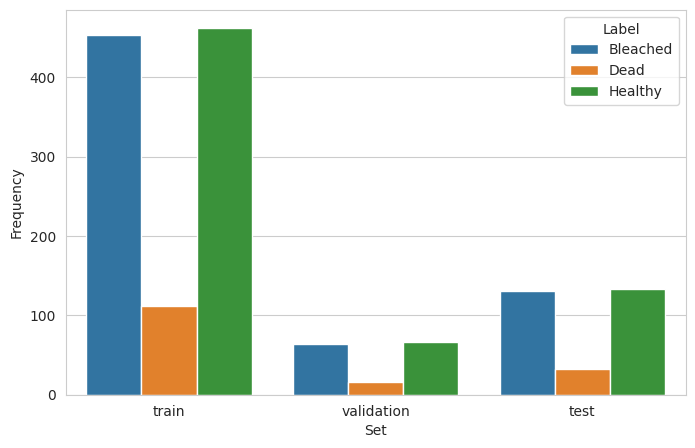

In [7]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Data augmentation

### ImageDataGenerator

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* Initialize ImageDataGenerator

In [9]:
augmented_image_data = ImageDataGenerator(rotation_range=30,
                                          width_shift_range=0.20,
                                          height_shift_range=0.20,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* Augment training dataset

In [10]:
batch_size = 32  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 1027 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Augment validation dataset

In [11]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 146 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

* Aurment test dataset

In [12]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 297 images belonging to 3 classes.


{'Bleached': 0, 'Dead': 1, 'Healthy': 2}

#### Plot augmented training image

(32, 227, 227, 3)


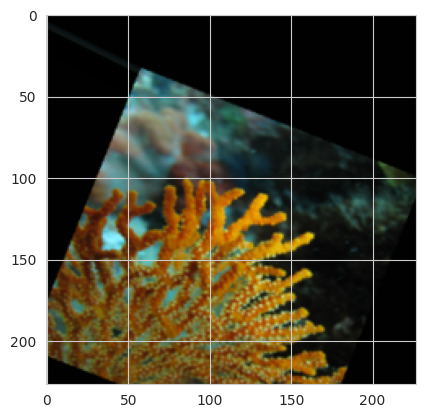

(32, 227, 227, 3)


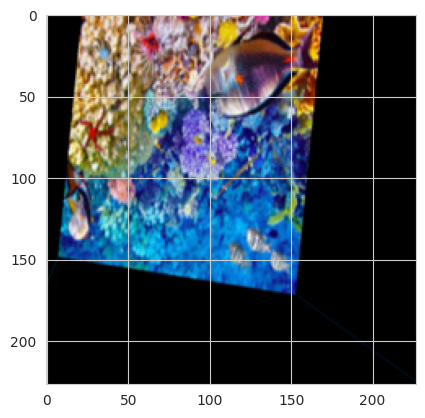

(32, 227, 227, 3)


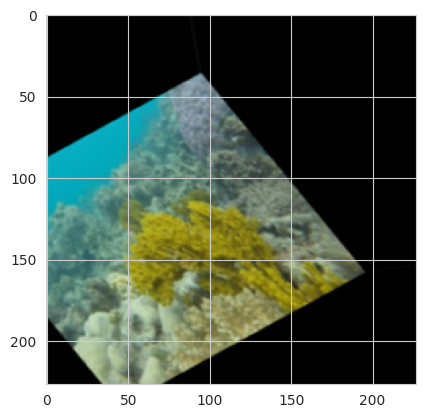

In [13]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented validation image

(32, 227, 227, 3)


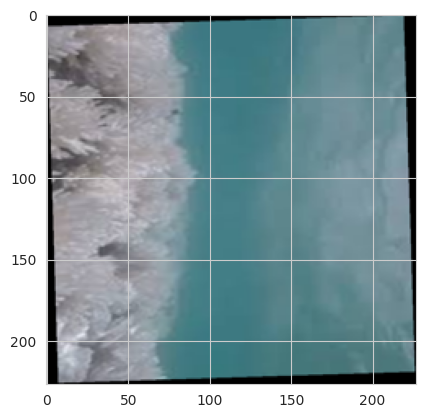

(32, 227, 227, 3)


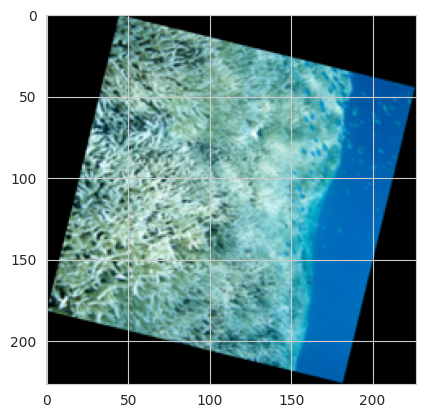

(32, 227, 227, 3)


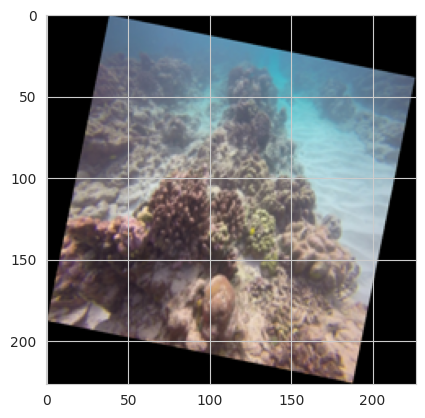

In [14]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

#### Plot augmented test image

(32, 227, 227, 3)


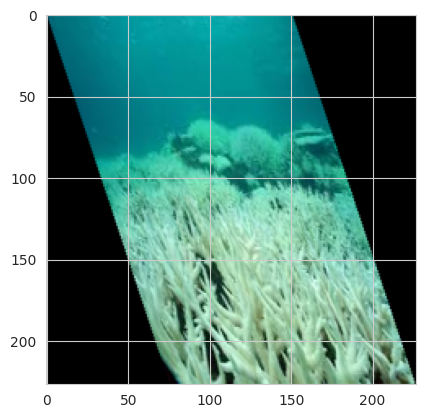

(32, 227, 227, 3)


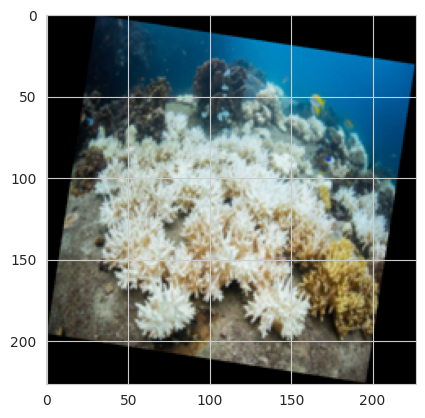

(32, 227, 227, 3)


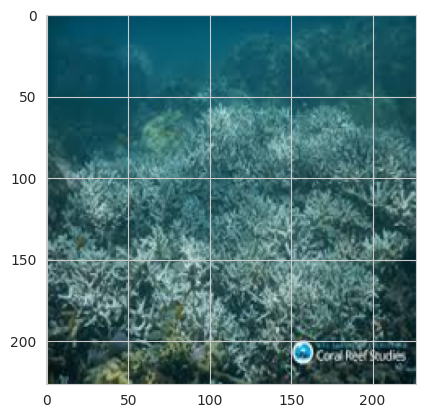

In [15]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [16]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v4/class_indices.pkl']

<hr>

## Building the models
<hr>

### Import model packages

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

### Models

#### Model_1
The model was adopted from [MalariaDetector walkthrough project](https://github.com/Code-Institute-Solutions/WalkthroughProject01.git) as a starting point. In this model, binary_crossentropy loss was substituted by categorical_crossentropy.

In [12]:
def create_tf_model_1():
    """
    Function that will create, compile and return a sequential model for classifying
    three types of images of corals ('healthy', 'bleached' and 'dead')
    """
    model = Sequential()
    

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
        

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
            

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
            

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [8]:
image_shape = (227, 227, 3)
create_tf_model_1().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

2024-08-27 11:27:21.062437: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Model_2
In this model, extra dropout layers were added.

In [9]:
def create_tf_model_2():
    """
    Function that will create, compile and return a sequential model for classifying
    three types of images of corals ('healthy', 'bleached' and 'dead')
    """
    model = Sequential()
    

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))   
        
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
        

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
        

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [10]:
image_shape = (227, 227, 3)
create_tf_model_2().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 53, 53, 64)       

#### Model_3
Complexity of the model is increased by adding extra Conv2D, MaxPooling2D and Dropout combination.

In [11]:
def create_tf_model_3():
    """
    Function that will create, compile and return a sequential model for classifying
    three types of images of corals ('healthy', 'bleached' and 'dead')
    """
    model = Sequential()
    

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))   
    

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
        

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
        

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [12]:
image_shape = (227, 227, 3)
create_tf_model_3().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 53, 53, 64)       

#### Define early stop

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit models for model training

In [14]:
model_1 = create_tf_model_1()
model_2 = create_tf_model_2()
model_3 = create_tf_model_3()

#### Fit model_1

In [90]:
model_1.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
32/32 [==============================] - 48s 2s/step - loss: 0.4730 - accuracy: 0.8201 - val_loss: 0.8624 - val_accuracy: 0.7397
Epoch 2/25
32/32 [==============================] - 57s 2s/step - loss: 0.4928 - accuracy: 0.8191 - val_loss: 0.5317 - val_accuracy: 0.7808
Epoch 3/25
32/32 [==============================] - 42s 1s/step - loss: 0.4247 - accuracy: 0.8322 - val_loss: 0.4407 - val_accuracy: 0.7945
Epoch 4/25
32/32 [==============================] - 45s 1s/step - loss: 0.4153 - accuracy: 0.8392 - val_loss: 0.4365 - val_accuracy: 0.8151
Epoch 5/25
32/32 [==============================] - 76s 2s/step - loss: 0.4390 - accuracy: 0.8221 - val_loss: 0.5324 - val_accuracy: 0.7671
Epoch 6/25
32/32 [==============================] - 51s 2s/step - loss: 0.4760 - accuracy: 0.8121 - val_loss: 0.4521 - val_accuracy: 0.8014
Epoch 7/25
32/32 [==============================] - 64s 2s/step - loss: 0.4584 - accuracy: 0.8161 - val_loss: 0.5146 - val_accuracy: 0.7808


In [91]:
model_1.save('outputs/v4/model_1.h5')

#### Fit model2

In [29]:
model_2.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
32/32 [==============================] - 53s 2s/step - loss: 0.9531 - accuracy: 0.6020 - val_loss: 0.6738 - val_accuracy: 0.7808
Epoch 2/25
32/32 [==============================] - 47s 1s/step - loss: 0.6312 - accuracy: 0.7618 - val_loss: 0.6511 - val_accuracy: 0.7603
Epoch 3/25
32/32 [==============================] - 47s 1s/step - loss: 0.5053 - accuracy: 0.8131 - val_loss: 0.5903 - val_accuracy: 0.7466
Epoch 4/25
32/32 [==============================] - 50s 2s/step - loss: 0.4726 - accuracy: 0.8211 - val_loss: 0.5001 - val_accuracy: 0.8014
Epoch 5/25
32/32 [==============================] - 65s 2s/step - loss: 0.4609 - accuracy: 0.8211 - val_loss: 0.4598 - val_accuracy: 0.8219
Epoch 6/25
32/32 [==============================] - 56s 2s/step - loss: 0.4591 - accuracy: 0.8231 - val_loss: 0.5366 - val_accuracy: 0.7603
Epoch 7/25
32/32 [==============================] - 49s 2s/step - loss: 0.4361 - accuracy: 0.8340 - val_loss: 0.4708 - val_accuracy: 0.8014
Epoch 8/25
32/32 [==

In [30]:
model_2.save('outputs/v4/model_2.h5')

#### Fit model_3

In [31]:
model_3.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
32/32 [==============================] - 51s 2s/step - loss: 0.9737 - accuracy: 0.4714 - val_loss: 0.8706 - val_accuracy: 0.4658
Epoch 2/25
32/32 [==============================] - 58s 2s/step - loss: 0.7045 - accuracy: 0.6925 - val_loss: 0.7376 - val_accuracy: 0.7123
Epoch 3/25
32/32 [==============================] - 50s 2s/step - loss: 0.5536 - accuracy: 0.7839 - val_loss: 0.6620 - val_accuracy: 0.7603
Epoch 4/25
32/32 [==============================] - 50s 2s/step - loss: 0.5089 - accuracy: 0.8020 - val_loss: 0.5742 - val_accuracy: 0.7945
Epoch 5/25
32/32 [==============================] - 50s 2s/step - loss: 0.4939 - accuracy: 0.8111 - val_loss: 0.5403 - val_accuracy: 0.7603
Epoch 6/25
32/32 [==============================] - 49s 2s/step - loss: 0.4400 - accuracy: 0.8312 - val_loss: 0.5069 - val_accuracy: 0.7671
Epoch 7/25
32/32 [==============================] - 52s 2s/step - loss: 0.4568 - accuracy: 0.8261 - val_loss: 0.5581 - val_accuracy: 0.8014
Epoch 8/25
32/32 [==

In [32]:
model_3.save('outputs/v4/model_3.h5')

<hr>

## Model performance<hr>

### Model learning curve

#### Model_1

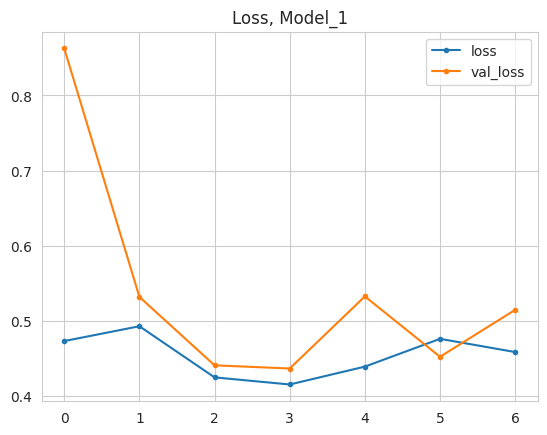

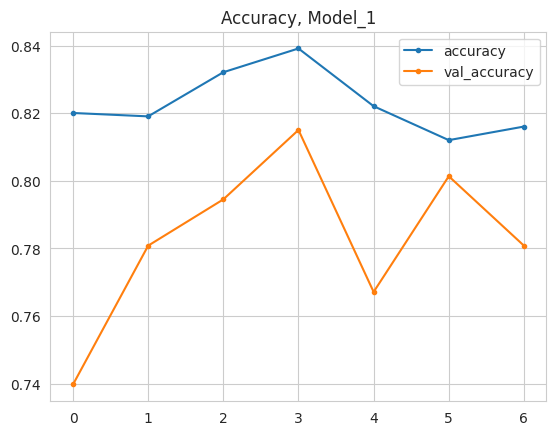

In [92]:
losses = pd.DataFrame(model_1.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss, Model_1")
plt.savefig(f'{file_path}/model_1_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy, Model_1")
plt.savefig(f'{file_path}/model_1_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

#### Model_2

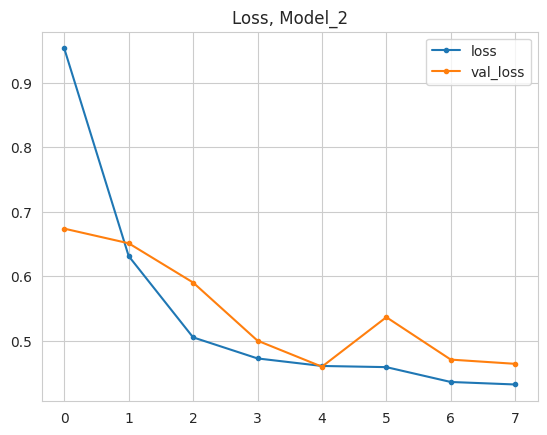

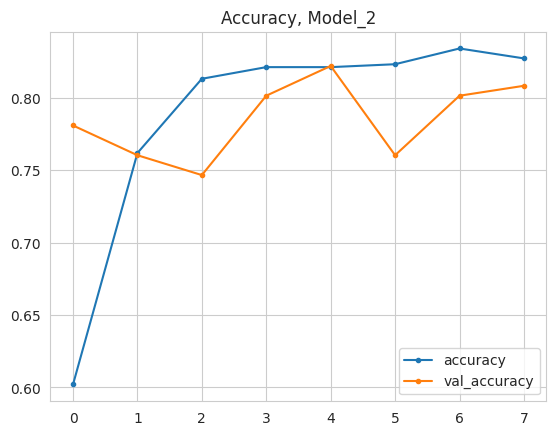

In [34]:
losses = pd.DataFrame(model_2.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss, Model_2")
plt.savefig(f'{file_path}/model_2_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy, Model_2")
plt.savefig(f'{file_path}/model_2_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

#### Model_3

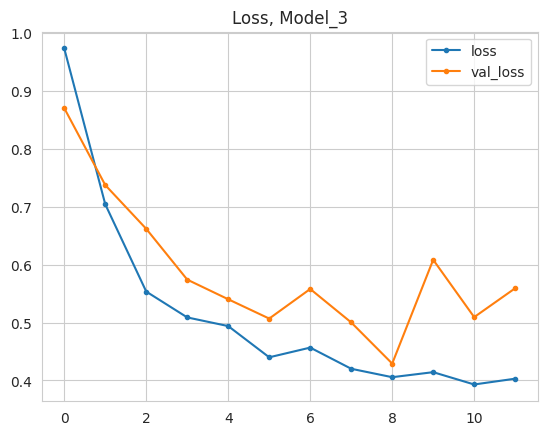

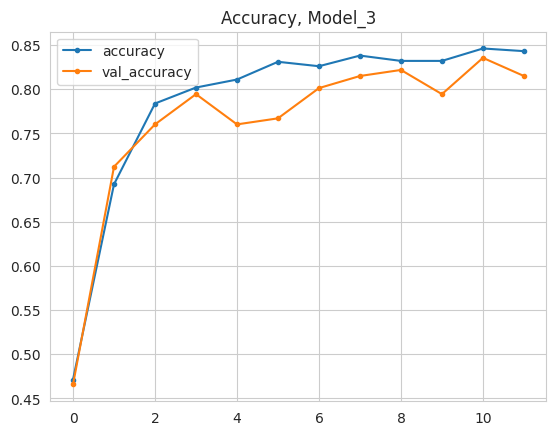

In [35]:
losses = pd.DataFrame(model_3.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss, Model_3")
plt.savefig(f'{file_path}/model_3_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy, Model_3")
plt.savefig(f'{file_path}/model_3_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model evaluation

#### Load model

In [10]:
from tensorflow.keras.models import load_model
model_1 = load_model(os.path.join('outputs', 'v4', 'model_1.h5'))
model_2 = load_model(os.path.join('outputs', 'v4', 'model_2.h5'))
model_3 = load_model(os.path.join('outputs', 'v4', 'model_3.h5'))

### Evaluate model on the test set

* Model_1

In [94]:
evaluation_model_1 = model_1.evaluate(test_set)

10/10 [==============================] - 5s 357ms/step - loss: 0.4456 - accuracy: 0.8249


* Model_2

In [39]:
evaluation_model_2 = model_2.evaluate(test_set)

10/10 [==============================] - 4s 399ms/step - loss: 0.4423 - accuracy: 0.8081


* Model_3

In [40]:
evaluation_model_3 = model_3.evaluate(test_set)

10/10 [==============================] - 3s 319ms/step - loss: 0.5171 - accuracy: 0.8519


### Save evaluation pickle

* Model_1

In [95]:
joblib.dump(value=evaluation_model_1,
            filename=f"outputs/v4/evaluation_model_1.pkl")

['outputs/v4/evaluation_model_1.pkl']

* Model_2

In [42]:
joblib.dump(value=evaluation_model_2,
            filename=f"outputs/v4/evaluation_model_2.pkl")

['outputs/v4/evaluation_model_2.pkl']

* Model_3

In [43]:
joblib.dump(value=evaluation_model_3,
            filename=f"outputs/v4/evaluation_model_3.pkl")

['outputs/v4/evaluation_model_3.pkl']

### Prediction on new data

#### Load random image as PIL

Healthy
['Bleached', 'Dead', 'Healthy']
Image shape: (227, 227), Image mode: RGB


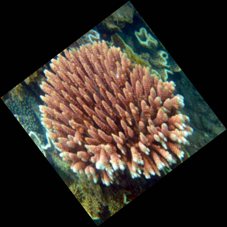

In [155]:
from tensorflow.keras.preprocessing import image

pointer = 19
label = labels[2] # '0 - Bleached', '1 - Dead', '2 - Healthy''.
print(label)
print(labels)

pil_image = image.load_img(os.path.join(test_path, label, os.listdir(test_path +'/' + label)[pointer]), target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

#### Convert image to array and prepare for prediction

In [156]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 227, 227, 3)


#### Predict class probabilities

In [157]:
target_map = {v: k for k, v in train_set.class_indices.items()}
print(f"Target map is: {target_map}")

pred_proba_model_1 = model_1.predict(my_image)[0]
print(f"Model_1 predicts: {pred_proba_model_1}")

pred_proba_model_2 = model_2.predict(my_image)[0]
print(f"Model_2 predicts: {pred_proba_model_2}")

pred_proba_model_3 = model_3.predict(my_image)[0]
print(f"Model_3 predicts: {pred_proba_model_3}")

Target map is: {0: 'Bleached', 1: 'Dead', 2: 'Healthy'}
Model_1 predicts: [0.1501961  0.00227382 0.84753   ]
Model_2 predicts: [0.2822027  0.20636763 0.51142967]
Model_3 predicts: [0.33465582 0.23662665 0.4287175 ]


In [158]:
prob_per_class_model_1 = pd.DataFrame(data=pred_proba_model_1, columns=['Probability'])
prob_per_class_model_2 = pd.DataFrame(data=pred_proba_model_2, columns=['Probability'])
prob_per_class_model_3 = pd.DataFrame(data=pred_proba_model_3, columns=['Probability'])

prob_per_class_model_1 = prob_per_class_model_1.round(3)
prob_per_class_model_2 = prob_per_class_model_2.round(3)
prob_per_class_model_3 = prob_per_class_model_3.round(3)

prob_per_class_model_1['Results'] = target_map.values()
prob_per_class_model_2['Results'] = target_map.values()
prob_per_class_model_3['Results'] = target_map.values()

print(prob_per_class_model_1)
print('=========================')
print(prob_per_class_model_2)
print('=========================')
print(prob_per_class_model_3)

   Probability   Results
0        0.150  Bleached
1        0.002      Dead
2        0.848   Healthy
   Probability   Results
0        0.282  Bleached
1        0.206      Dead
2        0.511   Healthy
   Probability   Results
0        0.335  Bleached
1        0.237      Dead
2        0.429   Healthy


## Plot probability prediction by different models

In [159]:
import pandas as pd
import plotly.express as px

# Combine the results into one DataFrame
combined_df = pd.concat([
    prob_per_class_model_1.assign(Model='Model 1'),
    prob_per_class_model_2.assign(Model='Model 2'),
    prob_per_class_model_3.assign(Model='Model 3')
])

# Plot the bar chart, grouped by Model
fig = px.bar(
    combined_df,
    x='Model',
    y='Probability',
    color='Results',
    barmode='group',
    range_y=[0, 1],
    width=600,
    height=400,
    template='seaborn',
    title="Probability by Model"
)

fig.show()
# Plot the bar chart, grouped by Coral Health State (Results)
fig = px.bar(
    combined_df,
    x='Results',
    y='Probability',
    color='Model',
    barmode='group',
    range_y=[0, 1],
    width=600,
    height=400,
    template='seaborn',
    title="Probability by Coral Health State"
)

fig.show()
